<a href="https://colab.research.google.com/github/Edwhite088/Resistor-calculator-using-machine-vision/blob/main/coursework_20022218.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all of the required libraries needed

In [4]:
import cv2
from google.colab.patches import cv2_imshow
from google. colab import runtime
import numpy as np
import PIL
from PIL import Image
import glob
import pathlib
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Add a dataset folder for the resistors

In [5]:
resistor_images = '/content/drive/MyDrive/dataset' #This is the dataset folder for resistor pictures
resistor_dataset = pathlib.Path(resistor_images) #This is to check how many images are in the folder
image_count = list(resistor_dataset.rglob('*'))
print(len(image_count)) #This tell us how many pictures I am using for teaching

120


Train the CNN

In [6]:
batch_size = 30 #The amount of pictures per file
img_height = 100 #Make them all the same height and width
img_width = 100

dataset_train = tf.keras.utils.image_dataset_from_directory( #This is to train the images using tenserflow
  resistor_images,
  validation_split=0.2, #This takes 20% of the images to do a validation check
  subset="training",
  seed=123,
  image_size=(img_height, img_width), #Says what the image size is
  batch_size=batch_size)

Found 114 files belonging to 2 classes.
Using 92 files for training.


In [7]:
validation = tf.keras.utils.image_dataset_from_directory( #This is to validate the images that have been sent through
  resistor_images,
  validation_split=0.2, #Uses 20% of the images to use for validation
  subset="validation",
  seed=123,
  image_size=(img_height, img_width), #Uses the image height and width for zoom
  batch_size=batch_size)

Found 114 files belonging to 2 classes.
Using 22 files for validation.


Check what class names have been made

In [8]:
class_names = dataset_train.class_names #This Prints the name of the files used for teaching aka resistor and empty
print(class_names)

['Resistor', 'empty']


shows in a random order what images are being used for training to avoid a rubish in rubish out situation

In [9]:
plt.figure(figsize=(170, 170)) #This zooms in the image to help train the model
for images, labels in dataset_train.take(1):
  for i in range(9): #Plots 9 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8")) #Prints 9 images
    plt.title(class_names[labels[i]]) #Prints 9 labels for the images
    plt.axis("off") #Turns off the axis labels

The CNN model

In [10]:
AUTOTUNE = tf.data.AUTOTUNE #Tunes the values used for training automatically

dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255) #This is to rescale the picture

In [11]:
normalized_dataset = dataset_train.map(lambda x, y: (normalization_layer(x), y)) #This is to normalize the picture
image_batch, labels_batch = next(iter(normalized_dataset))

In [12]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)), #This makes the images have an extra form of randomness to help train
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [13]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


In [15]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
epochs= 100
history = model.fit( #For some reason this doesnt work first time but if you run it again it works fine so....
  dataset_train,
  validation_data=validation,
  epochs=epochs
)

Epoch 1/100
4/4 [==============================] - 2s 265ms/step - loss: 0.7073 - accuracy: 0.5761 - val_loss: 0.9915 - val_accuracy: 0.3810
Epoch 2/100
4/4 [==============================] - 1s 216ms/step - loss: 0.6997 - accuracy: 0.7065 - val_loss: 1.2723 - val_accuracy: 0.3810
Epoch 3/100
4/4 [==============================] - 1s 223ms/step - loss: 0.6421 - accuracy: 0.7065 - val_loss: 0.8084 - val_accuracy: 0.3810
Epoch 4/100
4/4 [==============================] - 1s 303ms/step - loss: 0.6109 - accuracy: 0.7174 - val_loss: 0.9187 - val_accuracy: 0.3810
Epoch 5/100
4/4 [==============================] - 2s 368ms/step - loss: 0.6096 - accuracy: 0.7174 - val_loss: 1.1980 - val_accuracy: 0.3810
Epoch 6/100
4/4 [==============================] - 3s 1s/step - loss: 0.7097 - accuracy: 0.7174 - val_loss: 1.3323 - val_accuracy: 0.3810
Epoch 7/100
4/4 [==============================] - 1s 257ms/step - loss: 0.6252 - accuracy: 0.7174 - val_loss: 0.9333 - val_accuracy: 0.3810
Epoch 8/100
4/4 

Output in graph form

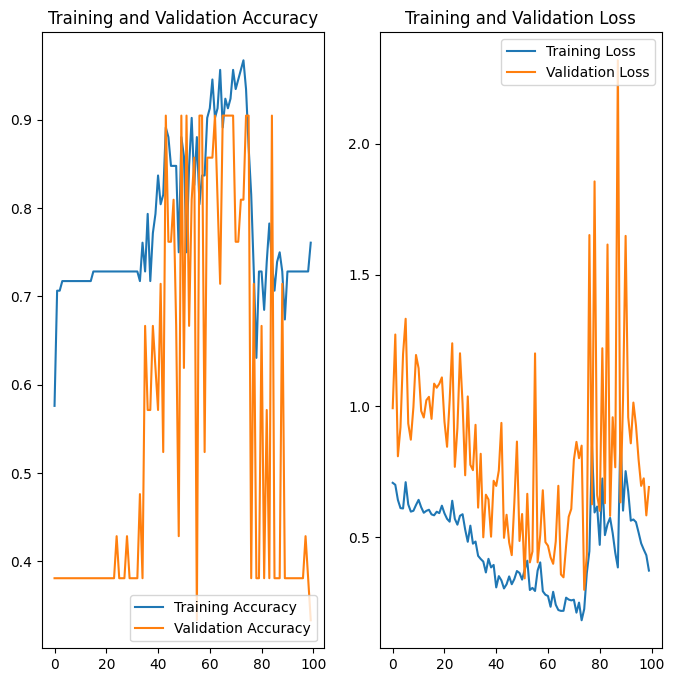

In [16]:
acc = history.history['accuracy'] #This is used to make graphs to plot the Accuracy and Loss
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs) #Gets how many epochs happened

plt.figure(figsize=(8, 8)) #Plots the graphs
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show() #Shows both of the graphs


Tells the user if the image they have inputted is a resistor or not

In [17]:
resistor_image_compare = '/content/drive/MyDrive/Image/Picture1.jpg' #This gets an image that the user defines
resistor_path = pathlib.Path(resistor_image_compare)

img = tf.keras.utils.load_img(resistor_path, target_size=(img_height, img_width)) #Trys to force the image to be the same size as the training images

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) #Create a batch

predictions = model.predict(img_array) #This is used to make a prediction
score = tf.nn.softmax(predictions[0])
print(score)

if(class_names[np.argmax(score)] == "Resistor"): #Checks if the prediction is a resistor
  print("This is a resistor")
else:
  print("This is not a resistor")
  runtime.unassign() #If it is not a resistor, this should end the google colab runtime

1/1 [==============================] - 0s 179ms/step
tf.Tensor([1.0000000e+00 2.3155604e-10], shape=(2,), dtype=float32)
This is a resistor


check if the resistor is horizonal or vertical, this need to be known for the calculations later

This is horizonal


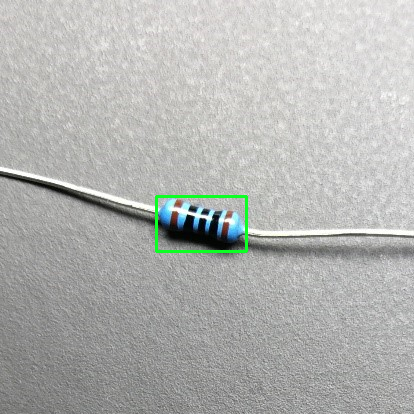

In [18]:
#Gets the image from drive
image = cv2.imread(resistor_image_compare)

#Copies the image for checking if there is a resistor in the image
check_resistor = image.copy()

#BGR to HSV
hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

#Gets the saturation channel
s_ch = hsv_img[:, :, 1]

#Works out the treshhold based on the saturation channel
#pixels above 16 are going to be 255, other are zeros.
thresh = cv2.threshold(s_ch,16, 240, cv2.THRESH_BINARY)[1]  # Apply threshold - pixels above 16 are going to be 255, other are zeros.
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)))  # Apply opening morphological operation for removing artifacts.

#Gets the x,y coords and the w,h
x,y,w,h = cv2.boundingRect(thresh)

#Puts the rectangle around the image if there is a resistor there
cv2.rectangle(check_resistor, (x, y), (x + w, y + h), (36,255,12), 2)

#Makes sure that the image is horizonal
if (w > h):
  print("This is horizonal")
  #Crops the image so all that is left is the resistor not the legs or background
  image = image[y:y+h, x:x+w]
#Changes the resistor to horizontal if necessary
else:
  image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
  image = image[y:y+w, x:+y]
cv2_imshow(check_resistor)


Zooms the image in on the resistor allowing a more accurate calculation

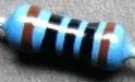

In [19]:
#Uses the coords from the middle of the box to get a bigger picture allowing it
#to seperate images better

#Defines how zoomed in the picture is
zoom = 1.5

#Resizes the image based of the image as an input, no movement, and zoom as
#scale factor along the x and y access
image = cv2.resize(image, (0, 0), fx=zoom, fy=zoom)

cv2_imshow(image)


Seperated the image into is red blue and green channels, cleans the image of noise and makes a mask to only get the bands

In [20]:
#Gets the blue channel
b = image.copy()

#Set green and red channels to 0
b[:, :, 1] = 0
b[:, :, 2] = 0


#Gets the green channel
g = image.copy()

#Set blue and red channels to 0
g[:, :, 0] = 0
g[:, :, 2] = 0

#Gets the red channel
r = image.copy()

#Set blue and green channels to 0
r[:, :, 0] = 0
r[:, :, 1] = 0

#Turns the blue image grey scale then binary to find only anything with a blue hue
b_grey = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
(thresh, b_binary) = cv2.threshold(b_grey, 10, 255, cv2.THRESH_BINARY)


#Turns the green image grey scale then binary to find only anything with a green hue
g_grey = cv2.cvtColor(g, cv2.COLOR_BGR2GRAY)
(thresh, g_binary) = cv2.threshold(g_grey, 60, 255, cv2.THRESH_BINARY)

#Turns the red image grey scale then binary to find only anything with a red hue
r_grey = cv2.cvtColor(r, cv2.COLOR_BGR2GRAY)
(thresh, r_binary) = cv2.threshold(r_grey, 50, 255, cv2.THRESH_BINARY)

#Adds the binary images together to get just the band colours
add1 = cv2.bitwise_and(b_binary, g_binary)
add2 = cv2.bitwise_and(add1, r_binary)

#Inverses the image so it can be used as a mask for the final image
inverse_im = cv2.bitwise_not(add2)

#Gets rid of all of the noise allowing a cleanish mask
gradient = cv2.morphologyEx(inverse_im, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)))


gets the rgb values of the resistor bands

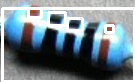

There are 5 resistor bands
(143, 71, 51)
(42, 58, 48)
(4, 7, 14)
(18, 22, 35)
(150, 83, 65)


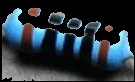

In [21]:
#Gets the x,y coords for the resistor
x,y,w,h = cv2.boundingRect(gradient)

#Puts the rectangle around the image to show if the resistor is horizontal or vertical allowing for no isses with colour finding
cv2.rectangle(gradient, (x, y), (x + w, y + h), (0,0,0), 2)




#Finds the resistor bands
band_count = image.copy()

#Finds contours allowing for multiple resistor bands to be found
contours = cv2.findContours(gradient, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

#Makes lists to store x,y coords and the mid points  of the rectangles
x_total =[]
y_total = []
mid_point_x = []
mid_point_y = []

#Counts the amount of resistor bands present in the picture
amount_of_rect = 0
for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
    cv2.rectangle(band_count, (x, y), (x+w, y+h), (255, 255, 255), 2)
    x_total.append(x)
    y_total.append(y)
    mid_point_x.append(w/2)
    mid_point_y.append(h/2)
    amount_of_rect += 1
cv2_imshow(band_count)
#Tells the user how many resistor bands there are
print("There are",amount_of_rect,"resistor bands")

#Makes the final mask
final = cv2.bitwise_or(image, image, mask = gradient)

#Turns the opencv image to a PIL image
final_pil = final.copy()
final_pil = cv2.cvtColor(final_pil, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(final_pil)
im_pil = im_pil.convert("RGB")
coords = []

#Finds the area where the colour value should be taken
for i in range(len(x_total)):
  place = (x_total[i] + mid_point_x[i]),(y_total[i] + mid_point_y[i])
  coords.append(place)

#Sorts out the coords in regards to x allowing to be read left to right
coords = sorted(coords)

total_colour = []

#This gets the pixel in the middle of the box making sure that the colour is
#from the resistor band
for j in range(len(x_total)):
  colour = im_pil.getpixel(coords[j])
  total_colour.append(colour)
  print(colour)

#Shows the final image
cv2_imshow(final)

Gets the closest actual colour from the rgb values

In [22]:
#gets the closest RBG value and assues that it is that colour
colours = ((0, 0, 0, "black"), (150, 75, 0, "brown"), (255, 0, 0, "red"),
          (255, 165, 0, "orange"), (255, 255, 0, "yellow"), (0, 255, 0, "green"),
          (0, 0, 255, "blue"), (127, 0, 255, "violet"), (128, 128, 128, "grey"),
          (255, 255, 255, "white"), (255, 215, 0, "gold"), (192, 192, 192, "silver"))

#Gets the nearest colour based on the colours set before hand
def nearest_colour( subjects, query ):
  return min( subjects, key = lambda subject: sum( (s - q) ** 2 for s, q in zip( subject, query ) ) )

colour_namelist_total = []
colour_namelist = []

#Gets the closed colour to the RBG values we have and gives them a name to make
#working out easier
for col in range(len(total_colour)):
  colour_namelist_total.append(nearest_colour(colours, (total_colour[col])))

#Gets the colour name from the list created from the colours
for r,g,b,colour in colour_namelist_total:
  colour_namelist.append(colour)
  print(colour)
#Checks if the resistor band is backwards for gold and silver so it does not
#break the calculations at the end
if(colour[0] == "gold" or colour[0] == "silver"):
  colour_namelist = list(reversed(colour_namelist))

brown
black
black
black
brown


In [ ]:
Finally outputs the final calculation of the resistor band

In [23]:
#Hash-map to store the values
#Of the color-digits
colour_digit = {'black': '0','brown': '1','red': '2','orange': '3','yellow': '4',
              'green' : '5','blue' : '6','violet' : '7','grey' : '8','white': '9'}

#Of the multiplier
multiplier = {'black': '1','brown': '10','red': '100','orange': '1k','yellow': '10k',
              'green' : '100k','blue' : '1M','violet' : '10M','grey' : '100M','white': '1G'}

#Of the tolerance
tolerance = {'brown': '+/- 1 %','red' : '+/- 2 %','green': "+/- 0.5 %",'blue': '+/- 0.25 %',
             'violet' : '+/- 0.1 %','gold': '+/- 5 %','silver' : '+/- 10 %'}

#Of the tolerance
PPM = {'brown': '100 ppm','red': '50 ppm','orange': '15 ppm','yellow': '25 ppm','blue': '10 ppm',
       'violet': '5 ppm'}

#Function to find the resistance
#For 4 band resistors
def findResistance4(a, b, c, d):
  if a in colour_digit and b in colour_digit and c in multiplier and d in tolerance:
    fir = colour_digit.get(a)
    sec = colour_digit.get(b)
    thr = multiplier.get(c)
    frth = tolerance.get(d)
    print("Resistance = "+fir + sec+ " x "+thr+" ohms "+frth)
  else:
    print("Invalid Colors")

#For 5 band resistors
def findResistance5(a, b, c, d, e):
  if a in colour_digit and b in colour_digit and c in colour_digit and d in multiplier and e in tolerance:
    fir = colour_digit.get(a)
    sec = colour_digit.get(b)
    thr = colour_digit.get(c)
    frth = multiplier.get(d)
    fif = tolerance.get(e)
    print("Resistance = "+fir + sec+ thr + " x "+frth+" ohms "+fif)
  else:
    print("Invalid Colors")

#For 6 band resistors
def findResistance6(a, b, c, d, e, f):
  if a in colour_digit and b in colour_digit and c in colour_digit and d in multiplier and e in tolerance and f in PPM:
    fir = colour_digit.get(a)
    sec = colour_digit.get(b)
    thr = colour_digit.get(c)
    frth = multiplier.get(d)
    fif = tolerance.get(e)
    six = PPM.get(f)
    print("Resistance = "+fir + sec+ thr + " x "+frth+" ohms "+fif + " PPM "+six)
  else:
    print("Invalid Colors")

#Gets the length of the amount of colours found
leng = len(colour_namelist)
if (leng == 4):
  a = colour_namelist[0]
  b = colour_namelist[1]
  c = colour_namelist[2]
  d = colour_namelist[3]

  findResistance4(a, b, c, d)

if (leng == 5):
  a = colour_namelist[0]
  b = colour_namelist[1]
  c = colour_namelist[2]
  d = colour_namelist[3]
  e = colour_namelist[4]
  findResistance5(a, b,c ,d, e)

if (leng == 6):
  a = colour_namelist[0]
  b = colour_namelist[1]
  c = colour_namelist[2]
  d = colour_namelist[3]
  e = colour_namelist[4]
  f = colour_namelist[5]
  findResistance6(a, b,c ,d, e, f)

#Checks if the resistor has the right amount of bands i.e 4,5 or 6
elif(leng != 4 and leng != 5 and leng != 6):
  print("Not a valid resistor")

Resistance = 100 x 1 ohms +/- 1 %
